In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikit_posthocs as sp
import seaborn as sns
from scipy.stats import shapiro, kruskal, mannwhitneyu, friedmanchisquare

# Aktualisierte Daten mit neuen Conditionsnamen
data = {
    'Sample': ['Crop1', 'Crop2', 'Crop3', 'Crop4', 'Crop5', 'Crop6', 'Crop7', 'Crop8', 'Crop9', 'Crop10', 'Crop11', 'Crop12'],
    'Control Center': [14.525, 10.525, 18.525, 18.525, 18.525, 14.525, 8.525, None, 18.525, 12.525, 10.525, 14.525],
    'Control Periphery': [20.525, 18.525, 18.525, 20.525, None, 18.525, 18.525, 18.525, 18.525, 18.525, None, 18.525],
    'Occluder Periphery': [None, 20.525, 18.525, 20.525, 20.525, None, None, 24.525, 20.525, None, None, 20.525],
    'Control Center (2)': [14.525, 16.525, None, 18.525, None, None, 16.525, 16.525, 18.525, 18.525, 12.525, 18.525],
    'Occluder Center': [20.525, 18.525, 18.525, None, None, 14.525, 18.525, 14.525, 18.525, None, 18.525, None],
    'Occluder Periphery (2)': [20.525, 20.525, None, 20.525, 20.525, 20.525, 18.525, 20.525, 20.525, None, None, None],
    'Red Filter Center': [12.525, 14.525, 12.525, 12.525, 12.525, 12.525, 14.525, 12.525, 12.525, 12.525, 16.525, None],
    'Red Filter Periphery': [26.525, 22.525, 22.525, None, 24.525, None, None, 24.525, None, 26.525, 22.525, 24.525]
}

# In ein DataFrame umwandeln
df = pd.DataFrame(data)

# None-Werte durch np.nan ersetzen
df.replace([None], np.nan, inplace=True)

df

,Sample,Control Center,Control Periphery,Occluder Periphery,Control Center (2),Occluder Center,Occluder Periphery (2),Red Filter Center,Red Filter Periphery
0,Crop1,14.525,20.525,NaN,14.525,20.525,20.525,12.525,26.525
1,Crop2,10.525,18.525,20.525,16.525,18.525,20.525,14.525,22.525
2,Crop3,18.525,18.525,18.525,NaN,18.525,NaN,12.525,22.525
3,Crop4,18.525,20.525,20.525,18.525,NaN,20.525,12.525,NaN
4,Crop5,18.525,NaN,20.525,NaN,NaN,20.525,12.525,24.525
5,Crop6,14.525,18.525,NaN,NaN,14.525,20.525,12.525,NaN
6,Crop7,8.525,18.525,NaN,16.525,18.525,18.525,14.525,NaN
7,Crop8,NaN,18.525,24.525,16.525,14.525,20.525,12.525,24.525
8,Crop9,18.525,18.525,20.525,18.525,18.525,20.525,12.525,NaN
9,Crop10,12.525,18.525,NaN,18.525,NaN,NaN,12.525,26.525


In [3]:
# DataFrame umformen - Beide Spalten 'Control_3Dcenter' und 'Control_3Dcenter (2)' zu einer gemeinsamen Bedingung
df_melted = pd.melt(df, id_vars="Sample", var_name="Condition", value_name="Value").dropna()

# Die Bedingungen 'Control_3Dcenter' und 'Control_3Dcenter (2)' in eine einzelne Bedingung "Control Center" umbenennen
df_melted['Condition'] = df_melted['Condition'].replace({
    'Control Center': 'Control Center',
    'Control Center (2)': 'Control Center',
    'Occluder Periphery': 'Occluder Periphery',
    'Occluder Periphery (2)': 'Occluder Periphery'
})

df_melted

,Sample,Condition,Value
0,Crop1,Control Center,14.525
1,Crop2,Control Center,10.525
2,Crop3,Control Center,18.525
3,Crop4,Control Center,18.525
4,Crop5,Control Center,18.525
...,...,...,...
88,Crop5,Red Filter Periphery,24.525
91,Crop8,Red Filter Periphery,24.525
93,Crop10,Red Filter Periphery,26.525
94,Crop11,Red Filter Periphery,22.525


In [4]:
def save_as_image(df, title, filename):
    col_widths = [max(len(str(x)) for x in df[col]) for col in df.columns]
    col_widths = [max(w, len(str(col))) * 0.15 for w, col in zip(col_widths, df.columns)]
    fig_width = sum(col_widths)
    fig_height = max(1, len(df) * 0.5)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('tight')
    ax.axis('off')
    ax.set_title(title, fontsize=16, pad=20)

    table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index,
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    for col_idx, col_width in enumerate(col_widths):
        for row_idx in range(len(df) + 1):
            cell = table[row_idx, col_idx]
            cell.set_width(col_width)

    for key, cell in table.get_celld().items():
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
        cell.set_text_props(ha='center', wrap=True)

    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.close(fig)

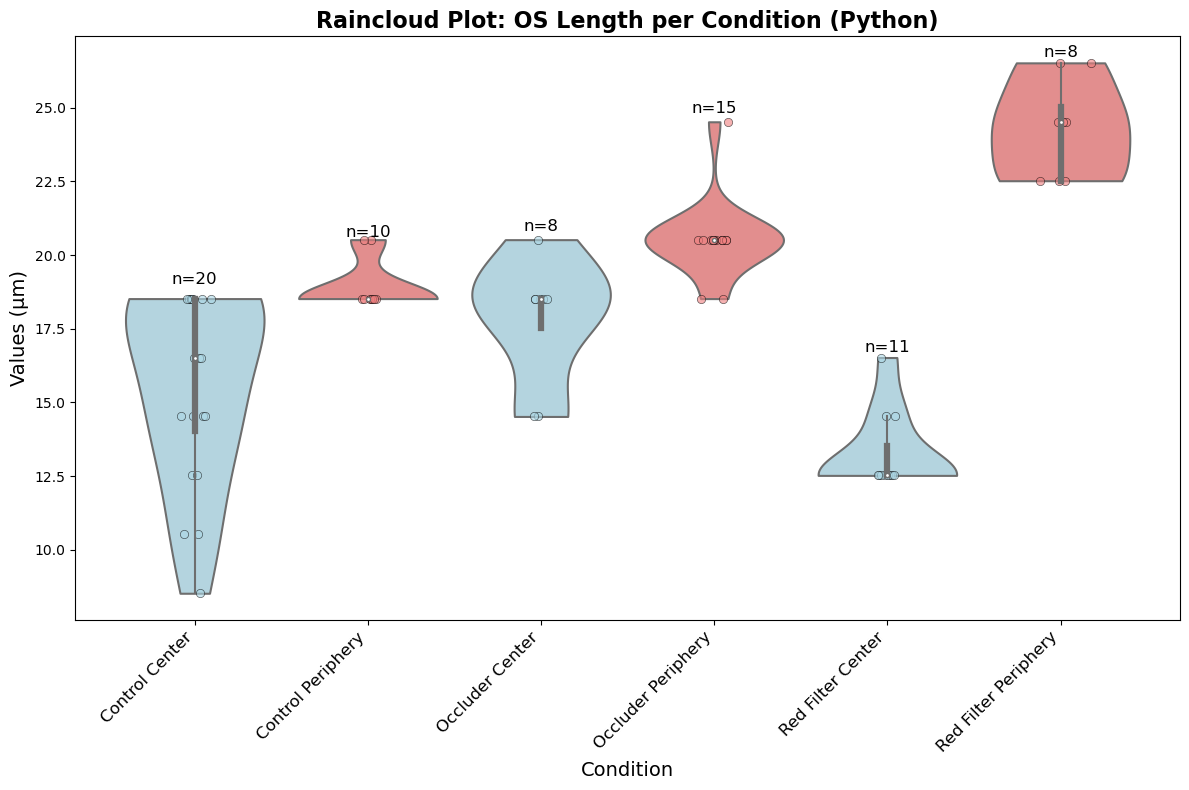

In [5]:
palette = {
    'Control Center': 'lightblue',
    'Control Periphery': 'lightcoral',
    'Occluder Center': 'lightblue',
    'Occluder Periphery': 'lightcoral',
    'Red Filter Center': 'lightblue',
    'Red Filter Periphery': 'lightcoral'
}

order = [
    'Control Center',
    'Control Periphery',
    'Occluder Center',
    'Occluder Periphery',
    'Red Filter Center',
    'Red Filter Periphery'
]

fig, ax = plt.subplots(figsize=(12, 8))

sns.violinplot(
    x="Condition", y="Value", data=df_melted, palette=palette, order=order, scale="width", cut=0, inner="box", ax=ax
)

for i, condition in enumerate(order):
    y_data = df_melted[df_melted["Condition"] == condition]["Value"]
    x_data = np.random.normal(loc=i, scale=0.05, size=len(y_data))
    ax.scatter(x_data, y_data, color=palette[condition], alpha=0.6, edgecolor="black", linewidth=0.5)
    ax.text(
        i, 
        max(y_data) + (max(y_data) - min(y_data)) * 0.05 if not y_data.empty else 0,
        f'n={len(y_data)}',
        ha='center', fontsize=12
    )

ax.set_title("Raincloud Plot: OS Length per Condition (Python)", fontsize=16, weight='bold')
ax.set_xlabel("Condition", fontsize=14)
ax.set_ylabel("Values (\u00b5m)", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)
plt.tight_layout()
plt.show()

# Speichern des Plots
# plt.savefig("Python_raincloud_plot.png", bbox_inches='tight', dpi=300)
plt.show()

In [8]:
############################################ Statistics

# Shapiro-Wilk Test für Normalverteilung
normality_results = df_melted.groupby("Condition")["Value"].apply(lambda x: shapiro(x.dropna()))
normality_summary = normality_results.apply(lambda x: {"W-statistic": x[0], "p-value": x[1]}).to_frame(name="Normality Test")

normality_summary

,Normality Test
Condition,
Control Center,{'p-value': 0.0058199320919811726}
Control Periphery,{'p-value': 4.6723621380806435e-06}
Occluder Center,{'p-value': 0.010757654905319214}
Occluder Periphery,{'p-value': 1.917636109283194e-05}
Red Filter Center,{'p-value': 4.404573337524198e-05}
Red Filter Periphery,{'p-value': 0.0672360211610794}


In [33]:
# Kruskal-Wallis Test (nicht-parametrisch)
groups = [df_melted[df_melted["Condition"] == condition]["Value"].dropna() for condition in df_melted["Condition"].unique()]
kruskal_stat, kruskal_p = kruskal(*groups)

print(kruskal_stat, kruskal_p)

56.02162584053793 8.043656642203373e-11


In [43]:
df

,Sample,Control Center,Control Periphery,Occluder Periphery,Control Center (2),Occluder Center,Occluder Periphery (2),Red Filter Center,Red Filter Periphery
0,Crop1,14.525,20.525,NaN,14.525,20.525,20.525,12.525,26.525
1,Crop2,10.525,18.525,20.525,16.525,18.525,20.525,14.525,22.525
2,Crop3,18.525,18.525,18.525,NaN,18.525,NaN,12.525,22.525
3,Crop4,18.525,20.525,20.525,18.525,NaN,20.525,12.525,NaN
4,Crop5,18.525,NaN,20.525,NaN,NaN,20.525,12.525,24.525
5,Crop6,14.525,18.525,NaN,NaN,14.525,20.525,12.525,NaN
6,Crop7,8.525,18.525,NaN,16.525,18.525,18.525,14.525,NaN
7,Crop8,NaN,18.525,24.525,16.525,14.525,20.525,12.525,24.525
8,Crop9,18.525,18.525,20.525,18.525,18.525,20.525,12.525,NaN
9,Crop10,12.525,18.525,NaN,18.525,NaN,NaN,12.525,26.525


In [12]:
# Mann-Whitney U Test für Center vs Center und Periphery vs Periphery
center_comparison = df_melted[df_melted["Condition"].isin(['Control Center', 'Occluder Center', 'Red Filter Center'])]
display(center_comparison)
periphery_comparison = df_melted[df_melted["Condition"].isin(['Control Periphery', 'Occluder Periphery', 'Red Filter Periphery'])]
display(periphery_comparison)

,Sample,Condition,Value
0,Crop1,Control Center,14.525
1,Crop2,Control Center,10.525
2,Crop3,Control Center,18.525
3,Crop4,Control Center,18.525
4,Crop5,Control Center,18.525
5,Crop6,Control Center,14.525
6,Crop7,Control Center,8.525
8,Crop9,Control Center,18.525
9,Crop10,Control Center,12.525
10,Crop11,Control Center,10.525


,Sample,Condition,Value
12,Crop1,Control Periphery,20.525
13,Crop2,Control Periphery,18.525
14,Crop3,Control Periphery,18.525
15,Crop4,Control Periphery,20.525
17,Crop6,Control Periphery,18.525
18,Crop7,Control Periphery,18.525
19,Crop8,Control Periphery,18.525
20,Crop9,Control Periphery,18.525
21,Crop10,Control Periphery,18.525
23,Crop12,Control Periphery,18.525


In [14]:
mannwhitney_center = []
mannwhitney_periphery = []

# Compare center vs center
for condition_1, condition_2 in [('Control Center', 'Occluder Center'),
                                  ('Control Center', 'Red Filter Center'),
                                  ('Occluder Center', 'Red Filter Center')]:
    group_1 = center_comparison[center_comparison["Condition"] == condition_1]['Value'].dropna()
    group_2 = center_comparison[center_comparison["Condition"] == condition_2]['Value'].dropna()

    u_stat, p_val = mannwhitneyu(group_1, group_2, alternative='two-sided')
    mannwhitney_center.append({
        'Condition_1': condition_1,
        'Condition_2': condition_2,
        'U-statistic': u_stat,
        'p-value': p_val
    })

# Compare periphery vs periphery
for condition_1, condition_2 in [('Control Periphery', 'Occluder Periphery'),
                                  ('Control Periphery', 'Red Filter Periphery'),
                                  ('Occluder Periphery', 'Red Filter Periphery')]:
    group_1 = periphery_comparison[periphery_comparison["Condition"] == condition_1]['Value'].dropna()
    group_2 = periphery_comparison[periphery_comparison["Condition"] == condition_2]['Value'].dropna()

    u_stat, p_val = mannwhitneyu(group_1, group_2, alternative='two-sided')
    mannwhitney_periphery.append({
        'Condition_1': condition_1,
        'Condition_2': condition_2,
        'U-statistic': u_stat,
        'p-value': p_val
    })

# Mann-Whitney U Test für Center vs Periphery innerhalb jeder Bedingung
center_periphery_comparison = df_melted[df_melted["Condition"].isin([
    'Control Center', 'Control Periphery',
    'Occluder Center', 'Occluder Periphery',
    'Red Filter Center', 'Red Filter Periphery'
])]

mannwhitney_center_vs_periphery = []

# Compare center vs periphery within each condition
for condition_1, condition_2 in [('Control Center', 'Control Periphery'),
                                  ('Occluder Center', 'Occluder Periphery'),
                                  ('Red Filter Center', 'Red Filter Periphery')]:
    group_1 = center_periphery_comparison[center_periphery_comparison["Condition"] == condition_1]['Value'].dropna()
    group_2 = center_periphery_comparison[center_periphery_comparison["Condition"] == condition_2]['Value'].dropna()

    u_stat, p_val = mannwhitneyu(group_1, group_2, alternative='two-sided')
    mannwhitney_center_vs_periphery.append({
        'Condition_1': condition_1,
        'Condition_2': condition_2,
        'U-statistic': u_stat,
        'p-value': p_val
    })

# Ergebnisse zusammenführen
mannwhitney_center_df = pd.DataFrame(mannwhitney_center)
mannwhitney_periphery_df = pd.DataFrame(mannwhitney_periphery)
display(mannwhitney_center_df)
display(mannwhitney_periphery_df)

,Condition_1,Condition_2,U-statistic,p-value
0,Control Center,Occluder Center,46.0,0.070809
1,Control Center,Red Filter Center,163.5,0.024052
2,Occluder Center,Red Filter Center,84.0,0.000586


,Condition_1,Condition_2,U-statistic,p-value
0,Control Periphery,Occluder Periphery,24.0,0.001327
1,Control Periphery,Red Filter Periphery,0.0,0.000221
2,Occluder Periphery,Red Filter Periphery,4.5,0.000119


In [17]:
combined_df = pd.concat([mannwhitney_center_df, 
                         mannwhitney_periphery_df,
                         pd.DataFrame(mannwhitney_center_vs_periphery)], 
                        keys=['Center vs Center', 'Periphery vs Periphery', 'Center vs Periphery within conditions'])
combined_df.reset_index(level=0, inplace=True)
combined_df.rename(columns={'level_0': 'Test Comparison'}, inplace=True)

combined_df

,Test Comparison,Condition_1,Condition_2,U-statistic,p-value
0,Center vs Center,Control Center,Occluder Center,46.0,0.070809
1,Center vs Center,Control Center,Red Filter Center,163.5,0.024052
2,Center vs Center,Occluder Center,Red Filter Center,84.0,0.000586
0,Periphery vs Periphery,Control Periphery,Occluder Periphery,24.0,0.001327
1,Periphery vs Periphery,Control Periphery,Red Filter Periphery,0.0,0.000221
2,Periphery vs Periphery,Occluder Periphery,Red Filter Periphery,4.5,0.000119
0,Center vs Periphery within conditions,Control Center,Control Periphery,32.0,0.001235
1,Center vs Periphery within conditions,Occluder Center,Occluder Periphery,13.0,0.000744
2,Center vs Periphery within conditions,Red Filter Center,Red Filter Periphery,0.0,0.000177


In [18]:
# Dunn-Test
control_center = df_melted[df_melted["Condition"] == 'Control Center']['Value'].dropna()
occluder_center = df_melted[df_melted["Condition"] == 'Occluder Center']['Value'].dropna()
redfilter_center = df_melted[df_melted["Condition"] == 'Red Filter Center']['Value'].dropna()

control_periphery = df_melted[df_melted["Condition"] == 'Control Periphery']['Value'].dropna()
occluder_periphery = df_melted[df_melted["Condition"] == 'Occluder Periphery']['Value'].dropna()
redfilter_periphery = df_melted[df_melted["Condition"] == 'Red Filter Periphery']['Value'].dropna()

In [30]:
# Dunn-Test mit Bonferroni-Korrektur durchführen
res_center = sp.posthoc_dunn([control_center, occluder_center, redfilter_center], p_adjust='bonferroni')
display(res_center)
res_periphery = sp.posthoc_dunn([control_periphery, occluder_periphery, redfilter_periphery], p_adjust='bonferroni')
display(res_periphery)
# Ergebnisse formatieren
test_results = {
    'Comparison': ['Occluder Center vs Control', 'Red Filter Center vs Control', 'Occluder Periphery vs Control', 'Red Filter Periphery vs Control'],
    'P-value': [
        res_center.iloc[1, 0], res_center.iloc[2, 0],  # Center-Vergleiche
        res_periphery.iloc[1, 0], res_periphery.iloc[2, 0]  # Periphery-Vergleiche
    ]
}
df_results = pd.DataFrame(test_results)
df_results = df_results.round(6)
df_results

,1,2,3
1,1.000000,0.219189,0.066552
2,0.219189,1.000000,0.001612
3,0.066552,0.001612,1.000000


,1,2,3
1,1.000000,0.055147,0.000004
2,0.055147,1.000000,0.006695
3,0.000004,0.006695,1.000000


,Comparison,P-value
0,Occluder Center vs Control,0.219189
1,Red Filter Center vs Control,0.066552
2,Occluder Periphery vs Control,0.055147
3,Red Filter Periphery vs Control,0.000004


In [32]:
occluder_center

48    20.525
49    18.525
50    18.525
53    14.525
54    18.525
55    14.525
56    18.525
58    18.525
Name: Value, dtype: float64

# Paired test

In [25]:
import numpy as np
import pandas as pd
import pingouin as pg
import matplotlib.pyplot as plt


# EyeCounting Datensatz (Goldstandard)
central_control_data_1 = [
    [45061.7284, 40000, 38765.4321],          # Chicken02
    [35308.64198, 37530.8642, 38518.51852],   # Chicken03
    [53209.87654, 59876.54321, 42716.04938],  # Chicken04
    [43086.41975, 44938.2716, 41975.30864],   # Chicken05
    [None],  # Chicken06
    [None],  # Chicken07
    [47901.23457]               # Chicken08 
]

peripheral_control_data_1 = [
    [31481.48148, 39012.34568, 30617.28395],  # Chicken02
    [36543.20988, 27160.49383, 28024.69136],  # Chicken03
    [51234.5679, 48395.06173, 51111.11111],   # Chicken04
    [31975.30864, 34074.07407, 34074.07407],  # Chicken05
    [28395.06173, 33827.16049, 35679.01235],  # Chicken06
    [40617.28395, 42345.67901, 37160.49383]   # Chicken07
]

central_treatment_data_1 = [
    [52222.22222, 46790.12346],  # Chicken02
    [35925.92593, 36172.83951, 43580.24691],  # Chicken03
    [45308.64198, 55802.46914, 50370.37037]   # Chicken04
]

peripheral_treatment_data_1 = [
    [34074.07407, 32469.1358],                # Chicken02
    [28271.60494],   # Chicken03
    [53703.7037, 35925.92593, 50740.74074]    # Chicken04
]

central_treatment2_data_1 = [
    [54444.44444, 38395.06173, 53209.87654],  # Chicken05
    [50000, 47283.95062],        # Chicken06
    [40617.28395, 41358.02469, 40740.74074],  # Chicken07
    [35679.01235, 37530.8642, 37407.40741]    # Chicken08
]

peripheral_treatment2_data_1 = [
    [43209.87654, 38024.69136, 37530.8642],   # Chicken05
    [39259.25926, 40617.28395, 40123.45679],  # Chicken06
    [44444.44444, 40987.65432, 40617.28395],  # Chicken07
    [37777.77778, 37777.77778]   # Chicken08
]

# ImageJ Datensatz (Methode 1)
central_control_data_2 = [
    [39629.62963, 40864.19753, 38271.60494],  # Chicken02
    [39259.25926, 42222.22222, 45679.01235],  # Chicken03
    [49876.54321, 55308.64198, 45185.18519],  # Chicken04
    [45555.55556, 44074.07407, 42716.04938],  # Chicken05
    [None],   # Chicken06
    [None],  # Chicken07
    [54567.90123]               # Chicken08 
]

peripheral_control_data_2 = [
    [31358.02469, 34938.2716, 31234.5679],    # Chicken02
    [32716.04938, 25308.64198, 29012.34568],  # Chicken03
    [45432.09877, 46543.20988, 47407.40741],  # Chicken04
    [35679.01235, 38148.14815, 40493.82716],  # Chicken05
    [33086.41975, 32839.50617, 35679.01235],  # Chicken06
    [42098.76543, 42098.76543, 36790.12346]   # Chicken07
]

central_treatment_data_2 = [
    [52345.67901, 46419.75309],  # Chicken02
    [35679.01235, 40123.45679, 42962.96296],  # Chicken03
    [50123.45679, 53456.79012, 47901.23457]   # Chicken04
]

peripheral_treatment_data_2 = [
    [35185.18519, 33333.33333],               # Chicken02
    [28271.60494],  # Chicken03
    [50987.65432, 40493.82716, 44691.35802]   # Chicken04
]

central_treatment2_data_2 = [
    [50370.37037, 40987.65432, 45308.64198],  # Chicken05
    [41604.93827, 39382.71605],  # Chicken06
    [47407.40741, 46172.83951, 51728.39506],  # Chicken07
    [37407.40741, 37654.32099, 40493.82716]   # Chicken08
]

peripheral_treatment2_data_2 = [
    [41234.5679, 33703.7037, 34691.35802],    # Chicken05
    [42716.04938, 38518.51852, 39753.08642],  # Chicken06
    [45925.92593, 42469.1358, 43827.16049],   # Chicken07
    [34814.81481, 36790.12346]   # Chicken08
]

# Python Datensatz (Methode 2)
central_control_data_3 = [
    [40987.6543, 45925.92593, 42839.50617],  # Chicken02
    [34938.2716, 35679.01235, 40246.91358],  # Chicken03
    [41234.5679, 47777.77778, 44444.44444],  # Chicken04
    [41728.39506, 39506.17284, 35925.92593],  # Chicken05
    [None],  # Chicken06
    [None],  # Chicken07
    [48765.4321]                # Chicken08 
]

peripheral_control_data_3 = [
    [28148.14815, 30370.37037, 32222.22222],  # Chicken02
    [36666.66667, 25802.46914, 24567.90123],  # Chicken03
    [51728.39506, 48395.06173, 50246.91358],  # Chicken04
    [39135.80247, 29259.25926, 38765.4321],   # Chicken05
    [33209.87654, 22345.67901, 44567.90123],  # Chicken06
    [33703.7037, 43456.79012, 34691.35802]    # Chicken07
]

central_treatment_data_3 = [
    [45061.7284, 44691.35802],   # Chicken02
    [35802.46914, 35185.18519, 40864.19753],  # Chicken03
    [42962.96296, 52962.96296, 41481.48148]   # Chicken04
]

peripheral_treatment_data_3 = [
    [26296.2963, 24938.2716],                 # Chicken02
    [23456.79012],  # Chicken03
    [57037.03704, 37037.03704, 50370.37037]   # Chicken04
]

central_treatment2_data_3 = [
    [50000, 40987.65432, 47901.23457],        # Chicken05
    [51975.30864, 36543.20988],  # Chicken06
    [40246.91358, 44197.53086, 60000],        # Chicken07
    [36913.58025, 32469.1358, 36296.2963]     # Chicken08
]

peripheral_treatment2_data_3 = [
    [33333.33333, 36049.38272, 30864.19753],  # Chicken05
    [48148.14815, 47407.40741, 46790.12346],  # Chicken06
    [33580.24691, 44814.81481, 47407.40741],  # Chicken07
    [35308.64198, 27037.03704]   # Chicken08
]

# Funktion zur Bereinigung der Daten
def clean_data(data):
    return [np.array([np.nan if x is None else x for x in sublist], dtype=float) for sublist in data]

# Funktion zur Erstellung eines DataFrames
def create_dataframe(data, condition, method, start_i=2):
    df = pd.DataFrame(data)
    df['Chicken'] = [f'Chicken{i+2}_{condition}' for i in range(len(data))]
    # df['Chicken'] = [f'Chicken{i+2}' for i in range(len(data))]
    df = df.melt(id_vars=['Chicken'], var_name='Measurement', value_name='Value')
    df['Condition'] = condition
    df['Method'] = method
    return df.dropna()

# Daten für jede Methode und Bedingung erstellen
data_eyecounting = pd.concat([
    create_dataframe(central_control_data_1, 'Central Control', 'EyeCounting'),
    create_dataframe(peripheral_control_data_1, 'Peripheral Control', 'EyeCounting'),
    create_dataframe(central_treatment_data_1, 'Central Treatment', 'EyeCounting'),
    create_dataframe(peripheral_treatment_data_1, 'Peripheral Treatment', 'EyeCounting'),
    create_dataframe(central_treatment2_data_1, 'Central Treatment 2', 'EyeCounting', 5),
    create_dataframe(peripheral_treatment2_data_1, 'Peripheral Treatment 2', 'EyeCounting', 5)
])

data_imagej = pd.concat([
    create_dataframe(central_control_data_2, 'Central Control', 'ImageJ'),
    create_dataframe(peripheral_control_data_2, 'Peripheral Control', 'ImageJ'),
    create_dataframe(central_treatment_data_2, 'Central Treatment', 'ImageJ'),
    create_dataframe(peripheral_treatment_data_2, 'Peripheral Treatment', 'ImageJ'),
    create_dataframe(central_treatment2_data_2, 'Central Treatment 2', 'ImageJ', 5),
    create_dataframe(peripheral_treatment2_data_2, 'Peripheral Treatment 2', 'ImageJ', 5)
])

data_python = pd.concat([
    create_dataframe(central_control_data_3, 'Central Control', 'Python'),
    create_dataframe(peripheral_control_data_3, 'Peripheral Control', 'Python'),
    create_dataframe(central_treatment_data_3, 'Central Treatment', 'Python'),
    create_dataframe(peripheral_treatment_data_3, 'Peripheral Treatment', 'Python'),
    create_dataframe(central_treatment2_data_3, 'Central Treatment 2', 'Python', 5),
    create_dataframe(peripheral_treatment2_data_3, 'Peripheral Treatment 2', 'Python', 5)
])

# Alle Daten kombinieren
all_data = pd.concat([data_eyecounting, data_imagej, data_python])
all_data

,Chicken,Measurement,Value,Condition,Method
0,Chicken2_Central Control,0,45061.72840,Central Control,EyeCounting
1,Chicken3_Central Control,0,35308.64198,Central Control,EyeCounting
2,Chicken4_Central Control,0,53209.87654,Central Control,EyeCounting
3,Chicken5_Central Control,0,43086.41975,Central Control,EyeCounting
6,Chicken8_Central Control,0,47901.23457,Central Control,EyeCounting
...,...,...,...,...,...
6,Chicken4_Peripheral Treatment 2,1,44814.81481,Peripheral Treatment 2,Python
7,Chicken5_Peripheral Treatment 2,1,27037.03704,Peripheral Treatment 2,Python
8,Chicken2_Peripheral Treatment 2,2,30864.19753,Peripheral Treatment 2,Python
9,Chicken3_Peripheral Treatment 2,2,46790.12346,Peripheral Treatment 2,Python


In [27]:
shapiro_results = []
methods = all_data['Method'].unique()

for method in methods:
    subset = all_data[all_data['Method'] == method]['Value']
    
    # Shapiro-Wilk-Test mit pingouin
    test_result = pg.normality(subset, method='shapiro')

    # Extraktion der relevanten Werte
    w_stat = test_result['W'].values[0]  # Teststatistik
    p_value = test_result['pval'].values[0]  # p-Wert
    
    # Ergebnisse speichern
    shapiro_results.append([method, round(w_stat, 4), round(p_value, 4)])

# Umwandlung der Ergebnisse in einen DataFrame
shapiro_df = pd.DataFrame(shapiro_results, columns=['Method', 'W-Value', 'p-Value'])
shapiro_shapiro_df = shapiro_df.round(4)
shapiro_shapiro_df

,Method,W-Value,p-Value
0,EyeCounting,0.9734,0.1613
1,ImageJ,0.9928,0.9672
2,Python,0.9884,0.7916


In [28]:
rm_anova = pg.rm_anova(data=all_data, dv='Value', within=['Method'], subject='Chicken', detailed=True)
rm_anova = rm_anova.round(4)

# Spaltennamen anpassen
rm_anova.rename(columns={
    'Source': 'Source',
    'SS': 'Sum of Squares (SS)',
    'DF': 'Degrees of Freedom (DF)',
    'MS': 'Mean Square (MS)',
    'F': 'F-Value',
    'p-unc': 'p-Value',
    'ng2': 'Partial Eta Squared (η²)',
    'eps': 'Epsilon'
}, inplace=True)
rm_anova

,Source,Sum of Squares (SS),Degrees of Freedom (DF),Mean Square (MS),F-Value,p-Value,Partial Eta Squared (η²),Epsilon
0,Method,5.326149e+07,2,2.663075e+07,3.8197,0.0289,0.0143,0.9679
1,Error,3.346517e+08,48,6.971909e+06,NaN,NaN,NaN,NaN


In [29]:
# Tukey's HSD durchführen
tukey_results = pg.pairwise_tukey(data=all_data, dv='Value', between='Method')

# Ergebnisse umbenennen und beschriften
tukey_results.rename(columns={
    'A': 'Method A',
    'B': 'Method B',
    'mean(A)': 'Mean A',
    'mean(B)': 'Mean B',
    'diff': 'Difference',
    'se': 'Standard Error',
    'T': 'T-value',
    'p-tukey': 'p-value (Tukey)',
    'hedges': 'Hedges g'
}, inplace=True)

# Rundung der Tukey-Ergebnisse auf 4 Nachkommastellen
tukey_results = tukey_results.round(4)
tukey_results

,Method A,Method B,Mean A,Mean B,Difference,Standard Error,T-value,p-value (Tukey),Hedges g
0,EyeCounting,ImageJ,41030.0350,41179.2887,-149.2537,1298.9819,-0.1149,0.9927,-0.0211
1,EyeCounting,Python,41030.0350,39607.5180,1422.5170,1298.9819,1.0951,0.5182,0.1784
2,ImageJ,Python,41179.2887,39607.5180,1571.7708,1298.9819,1.2100,0.4487,0.2061


In [30]:
# dependend t-test durchführen
paired_tests = pg.pairwise_tests(data=all_data, dv='Value', within='Method', subject='Chicken', parametric=False, marginal=True)

# Ergebnisse umbenennen und beschriften
paired_tests.rename(columns={
    'A': 'Method A',
    'B': 'Method B',
    'mean(A)': 'Mean A',
    'mean(B)': 'Mean B',
    'diff': 'Difference',
    'se': 'Standard Error',
    'T': 'T-value',
    'p-tukey': 'p-value (Tukey)',
    'hedges': 'Hedges g'
}, inplace=True)

# Rundung der Tukey-Ergebnisse auf 4 Nachkommastellen
paired_tests = paired_tests.round(4)
paired_tests

c:\Users\Bjoern\anaconda3\envs\MAIA\Lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,Contrast,Method A,Method B,Paired,Parametric,W-val,alternative,p-unc,Hedges g
0,Method,EyeCounting,ImageJ,True,False,148.0,two-sided,0.9658,-0.0270
1,Method,EyeCounting,Python,True,False,83.0,two-sided,0.0318,0.2270
2,Method,ImageJ,Python,True,False,73.0,two-sided,0.0288,0.2533
